This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.

- [ ] look at how estimate of ratio expected/actual for each gender varies as the proportion of data used for the estimate grows from 10% to 100%, (possibly using CV for each estimate)

In [1]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

Import the cleaned data:

In [2]:
%ls -lt ../../data/genre_lists/data_ready_for_model/

total 39824
-rw-r--r--  1 Daniel  staff    21724 Jun  9 11:47 genre_label_counts_TOTAL_2020-05-18-10-06.csv
-rw-r--r--@ 1 Daniel  staff   287510 Jun  4 13:42 genre_stats.html
-rw-r--r--@ 1 Daniel  staff   911587 Jun  4 13:39 genre_set_counts.html
-rw-r--r--@ 1 Daniel  staff     1845 Jun  4 13:11 female_bias_freq500.html
-rw-r--r--@ 1 Daniel  staff     1459 Jun  4 13:11 male_bias_freq500.html
-rw-r--r--  1 Daniel  staff    73746 May 29 10:19 genre_stats.csv
-rw-r--r--  1 Daniel  staff    66235 May 21 11:00 promiscuity_table.csv
-rw-r--r--  1 Daniel  staff    57474 May 20 12:47 corpus.mm.index
-rw-r--r--  1 Daniel  staff   382436 May 20 12:47 corpus.mm
-rw-r--r--  1 Daniel  staff    49966 May 20 12:47 genre_dictionary.dict
drwxr-xr-x  5 Daniel  staff      160 May 20 10:59 logistic_model_data/
-rw-r--r--  1 Daniel  staff    10926 May 18 11:10 genre_label_non-lonely_TRAINING_2020-05-18-10-06.csv
-rw-r--r--  1 Daniel  staff     8664 May 18 11:09 genre_label_lonely_TRAINING_2020-05-18-10-06.

In [3]:
%store -r now
now
#now = '2020-05-11-14-35'

'2020-05-18-10-06'

In [4]:
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

In [5]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,['country'],1
La_Palabra,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,"['r_and_b', 'soul']",2
Allen_Collins,['southern_rock'],1


In [6]:
X_train.shape, y_train.shape

((12376, 2), (12376, 1))

In [7]:
data = y_train.join( [X_train], how = 'outer')

In [8]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,male,['country'],1
La_Palabra,male,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,male,"['r_and_b', 'soul']",2
Allen_Collins,male,['southern_rock'],1


In [9]:
data.shape, data.isnull().sum()

((12376, 3),
 gender              0
 genrelist           0
 genrelist_length    0
 dtype: int64)

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [10]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [11]:
data['genrelist']= data['genrelist'].apply(genrelist)

In [12]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"[pop, rock, emo_pop]",3
Bobby_Edwards,male,[country],1
La_Palabra,male,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4
Sherrick,male,"[r_and_b, soul]",2
Allen_Collins,male,[southern_rock],1


### Extract unique genre labels: 

### This is for the training set:

In [13]:
# genre_list = data.genrelist.values.tolist()
# genre_list = [x for y in genre_list for x in y]
# genre_list = list(set(genre_list))

### Import the labels from the whole data set:

In [14]:
then = '2020-05-11-14-34'

In [15]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [16]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [17]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [18]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    # bin 11 count and above
    df.at['11+'] = df.iloc[10:,:].sum()
    
    # calculated columns: relative and ratios
    df['female_relative'] = round(df['female']/fem,3)
    df['male_relative'] = round(df['male']/mal,3)

    df['ratio'] = round(df['male_relative']/df['female_relative'],3)

    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [19]:
lcbg = create_length_counts_by_gender(data)

In [20]:
lcbg

,total,female,male,female_relative,male_relative,ratio
genrelist_length,,,,,,
1,3561.0,1031.0,2530.0,0.268,0.297,1.108
2,3067.0,1030.0,2037.0,0.268,0.239,0.892
3,2488.0,854.0,1634.0,0.222,0.192,0.865
4,1594.0,502.0,1092.0,0.130,0.128,0.985
5,850.0,243.0,607.0,0.063,0.071,1.127
6,462.0,127.0,335.0,0.033,0.039,1.182
7,181.0,27.0,154.0,0.007,0.018,2.571
8,92.0,15.0,77.0,0.004,0.009,2.250
9,37.0,9.0,28.0,0.002,0.003,1.500


### The bin_cv_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [21]:
def bin_cv_est(df):
    
    twobins_folds_train = pd.DataFrame(index = pd.MultiIndex.from_tuples([(0,'1-5'), (0,'>6')]), 
                                   columns = ['male_act_exp_ratio', 'female_act_exp_ratio'])
    twobins_folds_test = pd.DataFrame(index = pd.MultiIndex.from_tuples([(0,'1-5'), (0,'>6')]), 
                                   columns = ['male_act_exp_ratio', 'female_act_exp_ratio'])
    
    kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

    fold = 0
    for train, test in kf.split(df.genrelist_length.values): #use any column to define the train, test index sets
        data_train = df.iloc[train]
        data_test = df.iloc[test]

        # create length counts by gender
        lcbg_train = create_length_counts_by_gender(data_train)
        lcbg_test = create_length_counts_by_gender(data_test)

        # remove unused columns
        lcbg_train.drop(['female_relative','male_relative','ratio'], axis = 1, inplace = True)
        lcbg_test.drop(['female_relative','male_relative','ratio'], axis = 1, inplace = True)
        
        # mark rows by their class (uses ordering; could be done with masking)
        lcbg_train['classify'] = '1-5'
        lcbg_train.iloc[6:,-1] = '>6'
        
        lcbg_test['classify'] = '1-5'
        lcbg_test.iloc[6:,-1] = '>6'
        
        # calculate totals for each bin
        twobins_train = lcbg_train.groupby(['classify']).agg('sum')
        twobins_test = lcbg_test.groupby(['classify']).agg('sum')
        
        # calculated columns: expected and ratios - train
        twobins_train['expected female'] = (.31*twobins_train['total']).astype('int64')
        twobins_train['expected male'] = (.69*twobins_train['total']).astype('int64')
        twobins_train['male_act_exp_ratio'] =twobins_train['male']/ twobins_train['expected male']
        twobins_train['female_act_exp_ratio'] =  twobins_train['female']/ twobins_train['expected female']
        
        # calculated columns: expected and ratios - test
        twobins_test['expected female'] = (.31*twobins_test['total']).astype('int64')
        twobins_test['expected male'] = (.69*twobins_test['total']).astype('int64')
        twobins_test['male_act_exp_ratio'] =twobins_test['male']/ twobins_test['expected male']
        twobins_test['female_act_exp_ratio'] =  twobins_test['female']/ twobins_test['expected female']
        
        # only keep needed columns
        twobins_train = twobins_train[['male_act_exp_ratio','female_act_exp_ratio']]
        twobins_test = twobins_test[['male_act_exp_ratio','female_act_exp_ratio']]
        
        # create multiindex
        twobins_train.index = index = pd.MultiIndex.from_tuples([(fold+1,'1-5'), (fold+1,'>6')])
        twobins_test.index = index = pd.MultiIndex.from_tuples([(fold+1,'1-5'), (fold+1,'>6')])
        
        # concatenate with earlier folds
        twobins_folds_train = pd.concat([twobins_folds_train, twobins_train])
        twobins_folds_test = pd.concat([twobins_folds_test, twobins_test])
        
        fold += 1
    
    # drop the empty first two rows used to initialize the DF
    twobins_folds_train = twobins_folds_train.iloc[2:]
    twobins_folds_test = twobins_folds_test.iloc[2:]
    
    # calculate errors: train - test
    folds_errors = twobins_folds_train-twobins_folds_test
    
    # return the predicted values and the errors for each fold
    return twobins_folds_train, twobins_folds_test, folds_errors



## Calculate mean and std

In [22]:
twobins_folds_train, twobins_folds_test, folds_errors = bin_cv_est(data)

Calculate mean and std on the train set of each fold:

In [23]:
twobins_folds_train_mean = twobins_folds_train.mean(level = 1)
twobins_folds_train_mean

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.992807,1.016310
>6,1.199236,0.564687


In [24]:
twobins_folds_train_std = twobins_folds_train.std(level = 1)
twobins_folds_train_std

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.001796,0.003998
>6,0.011393,0.024469


Calculate mean and std on the test set of each fold:

In [25]:
twobins_folds_test.mean(level = 1)

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.993151,1.017955
>6,1.218467,0.588852


In [26]:
twobins_folds_test.std(level = 1)

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.016234,0.036172
>6,0.084526,0.194243


Calculate the abs(error) from each fold and take mean:

In [27]:
folds_errors_abs = np.abs(folds_errors)
folds_errors_abs.mean(level = 1)

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.014561,0.032445
>6,0.076147,0.154822


In [28]:
folds_errors_abs.std(level = 1)

,male_act_exp_ratio,female_act_exp_ratio
1-5,0.009466,0.021137
>6,0.055868,0.147521


### Visualize

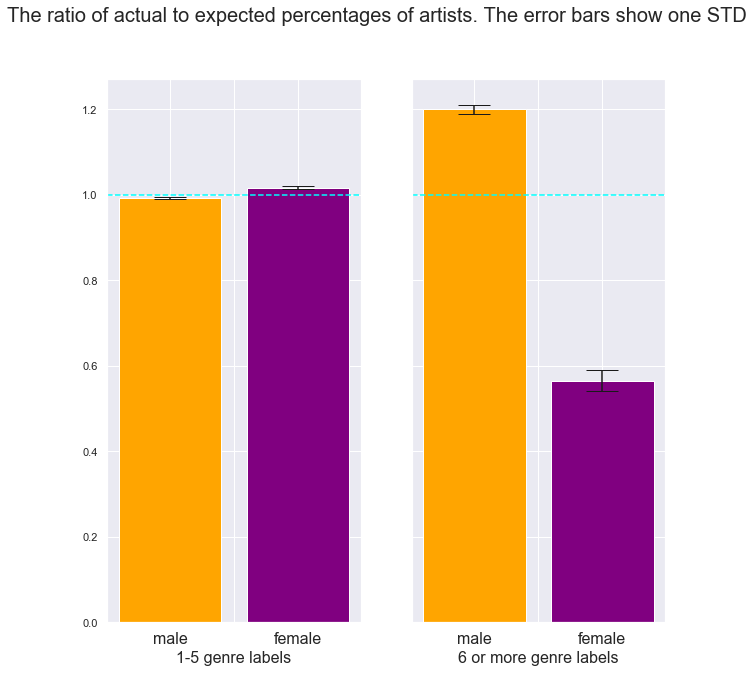

In [31]:
df = twobins_folds_train_mean
eb = twobins_folds_train_std
fig, axs = plt.subplots(1,2, sharey = True, figsize = (10,10))
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar([0,1],df.iloc[0].to_list(), color = ['orange','purple'], yerr = eb.iloc[0].to_list(), capsize = 16)
axs[1].bar([0,1],df.iloc[1].to_list(), color = ['orange','purple'], yerr = eb.iloc[1].to_list(), capsize = 16)
axs[0].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[1].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[0].set_xlabel('1-5 genre labels', fontsize = 16)
axs[1].set_xlabel('6 or more genre labels', fontsize = 16)
axs[0].axhline(1, color = 'cyan', ls = '--')
axs[1].axhline(1, color = 'cyan', ls = '--')
plt.setp(axs[1].get_yticklabels(), visible=False)
#caption = 'This is'
#fig.text(caption)
fig.savefig(fname = '/Users/Daniel/Code/Genre/visualizations/twobins_plot.png', format = 'png', dpi = 'figure')

In [88]:
# folds_train_test = folds_train.join(folds_test, lsuffix = '_train', rsuffix = '_test', how = 'right')

### Look at how the mean ratios vary with the size of the set used to estimate.